In [1]:
# Importar librerias
import requests                    
import pandas as pd
import time             
import matplotlib.pyplot as plt    
import seaborn as sns               
import numpy as np                  
import datetime
import json
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors

## "Japón."

Los datos sísmicos se descargaron a través de [JMA](https://www.data.jma.go.jp/multi/quake/index.html?lang=es) (agencia meteorologica de Japón).

El analisis se realiza en un intervalo de inicio el 01 de enero de 2023 y fin el 11 de mayo de 2023, o sea en un periodo de 130 días.

In [2]:
periodo_en_dias = (datetime.datetime(2023,5,11) - datetime.datetime(2023,1,1)).days
print('El periodo en días es igual a',periodo_en_dias,'días')

El periodo en días es igual a 130 días


Realizar la extraccion y creacion del DataFrame desde el enlace.

In [3]:
    
def extraccion_japon():
    
    # Crear enlace a la página web.
    japon = "https://service.iris.edu/fdsnws/event/1/query?starttime=2023-01-01T00:00:00&&endtime=2023-05-11T23:59:59&orderby=time&format=geocsv&maxlat=47.587&minlon=128.288&maxlon=157.029&minlat=30.234&nodata=404"
    
    # Crear dataframe con la tabla extraida del enlace.
    japon = pd.read_csv(japon, sep='|', skiprows=4)

    # Filtrar la palabra JAPAN en la variable EventLocationName.
    japon = japon[japon.EventLocationName.str.contains('JAPAN')]

    return japon

japon = extraccion_japon()

Visualizar los primeros elementos del DataFrame.

In [4]:
japon.head()

,EventID,Time,Latitude,Longitude,Depth,Author,Catalog,Contributor,ContributorID,MagType,Magnitude,MagAuthor,EventLocationName
0,11694723,2023-05-11T09:52:44Z,42.3324,142.9855,63.921,us,NEIC PDE,us,us6000kb2d,Mww,5.2,us,"HOKKAIDO, JAPAN REGION"
1,11694572,2023-05-10T21:04:24Z,31.4516,138.4022,363.835,us,NEIC PDE,us,us6000kazb,mb,4.1,us,"SOUTHEAST OF HONSHU, JAPAN"
2,11694590,2023-05-10T19:16:42Z,35.1178,140.0649,38.465,us,NEIC PDE,us,us6000kayd,Mwr,5.2,us,"NEAR EAST COAST OF HONSHU, JAPAN"
3,11694222,2023-05-10T12:54:48Z,37.5782,137.3084,10.000,us,NEIC PDE,us,us6000kau6,mb,5.0,us,"NEAR WEST COAST OF HONSHU, JAPAN"
4,11695102,2023-05-10T02:20:56Z,35.7564,139.9843,63.385,us,NEIC PDE,us,us6000karz,mb,4.5,us,"NEAR S. COAST OF HONSHU, JAPAN"


Determinar el significado de cada variable.

- __EventID:__ _Identificador del evento._
- __Time:__ _Fecha y hora del evento._
- __Latitude:__ _Latitud del epicentro del sismo._
- __Longitude:__ _Longitud del epicentro del sismo._
- __Depth:__ _Profundidad del epicentro del sismo._
- __Author:__ _Autor de los datos del evento._
- __Catalog:__ _Catálogo al que pertenece el evento._
- __Contributor:__ _Nombre del grupo que contribuye al evento._
- __ContributorID:__ _Identificador del contribuidor._
- __MagType:__ _Método de cálculo preferido de la magnitud del evento._
- __Magnitude:__ _Magnitud del evento._
- __MagAuthor:__ _Autor de la medida de magnitud._
- __EventLocationName:__ _Lugar del evento._
- __Country:__ _País donde ocurrió el evento._

La siguiente grafica determina que no existen valores faltantes en el DataFrame.

Text(0.5, 1.0, 'Porcentaje de datos por variable')

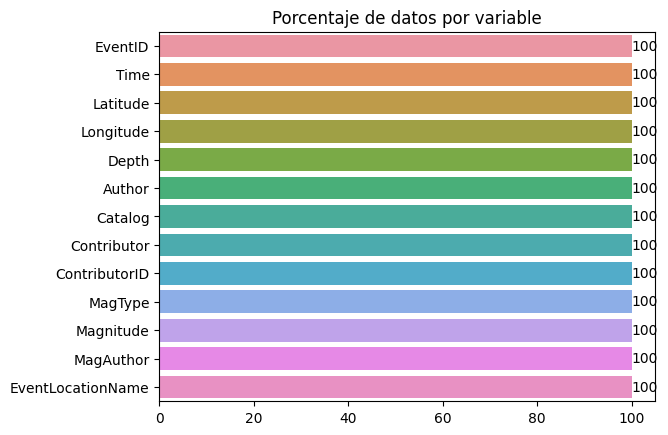

In [4]:
def datos_faltantes(pais):
    ax = sns.barplot(x = (pais.notnull().sum()*100/pais.shape[0]).values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Porcentaje de datos por variable')

datos_faltantes(japon)

In [37]:
print('El total de sismos en 130 días de Japón es', japon.shape[0])
print('La menor magnitud registrada es', japon.Magnitude.min())
print('La mayor magnitud registrada es',japon.Magnitude.max())

El total de sismos en 130 días de Japón es 193
La menor magnitud registrada es 3.9
La mayor magnitud registrada es 6.2


Las variables __Catalog__, __Contributor__ y __MagAuthor__ contienen un único valor, por lo tanto al ser un valor constante se deben eliminar.

Text(0.5, 1.0, 'Cantidad de valores únicos por variable')

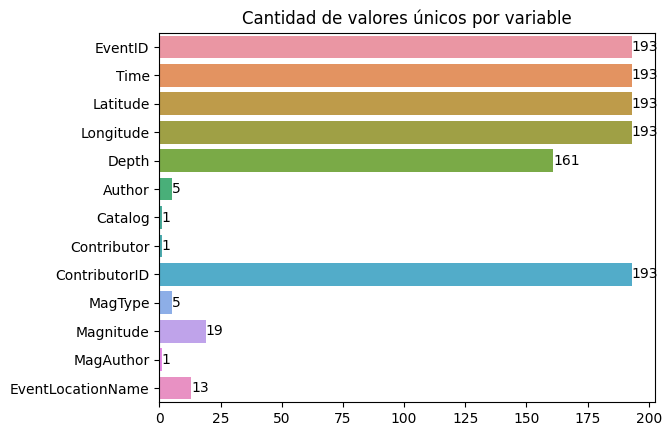

In [45]:
def valor_unico(pais):
    ax = sns.barplot(x = pais.nunique().values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Cantidad de valores únicos por variable')

valor_unico(japon)

El mapa de correlaciones determina que no existe correlacion lineal entre variables.

Text(0.5, 1.0, 'Mapa de correlacion')

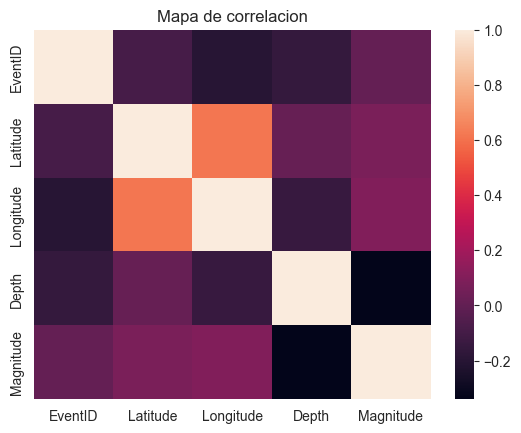

In [ ]:
def mapa_correlacion(pais):

    sns.heatmap(pais.corr(numeric_only=True))
    return plt.title('Mapa de correlacion')

mapa_correlacion(japon)

In [22]:
japon['Latitude'].min()
japon['Latitude'].min()
japon['Longitude'].max()
japon['Longitude'].max()

KeyError: 'Latitude'

Los siguientes graficos determinan la distribucion sismica por region y la magnitude predominante: alrededor de 4.3 grados.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8252\675136046.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'),bbox= (154.205541,20.2145811,122.7141754 ,45.7112046))


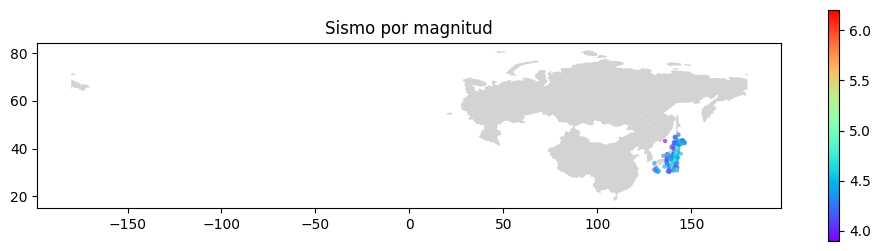

In [25]:

def mapa_sismo(pais):
    # https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    # Escogemos el mapa
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'),bbox= (154.205541,20.2145811,122.7141754 ,45.7112046))
    # Creamos el objeto geodataframe
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(pais['Longitude'], pais['Latitude'])]
    geo_df = gpd.GeoDataFrame(pais, 
                            crs = crs, 
                            geometry = geometry)

    # por magnitud
    fig, ax = plt.subplots(figsize = (12,10))

    world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

    geo_df.plot(column = 'Magnitude', ax=ax, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 5, alpha=0.5)
                
    ax.set_title('Sismo por magnitud')

mapa_sismo(japon)

C:\Users\Edwar\AppData\Local\Temp\ipykernel_15344\3808207733.py:3: UserWarning: 
The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.
  return sns.displot(pais, x="Magnitude",hue='EventLocationName',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])


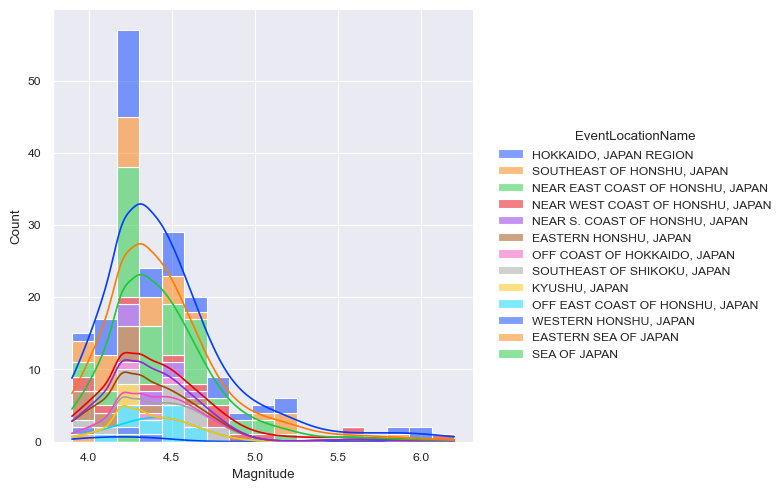

In [ ]:

def magnitud_region(pais):
    
    return sns.displot(pais, x="Magnitude",hue='EventLocationName',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])

magnitud_region(japon)

_Transformaciones_.

Ordenar la variable __Fecha__.

In [11]:
def separate_date_time(pais):
    def separate_date(row):
        part = row.Time.split("T")
        row['date'] = part[0]
        row['time'] = part[1].strip("Z")
        return row
    pais = pais.apply(separate_date, axis=1)
    

    return pais

japon = separate_date_time(japon)

Eliminar variables consideradas innecesarias.

In [12]:
def eliminar_variables(pais):
    pais = pais.drop(['EventID', 'Author', 'Catalog', 'Contributor','ContributorID','MagType','MagAuthor','EventLocationName','Time'], 
            axis='columns')
    
    return pais

japon = eliminar_variables(japon)

Renombrar y ordenar variables.

In [13]:
def renombrar_vaiables(pais):

    pais = pais.rename(columns={"Latitude":"latitude","Longitude":"longitude","Depth":"depth","Magnitude":"magnitude"})
    pais = pais[['date','time',	'magnitude','depth','latitude','longitude']]
    return pais

japon = renombrar_vaiables(japon)

Comprobar el tipo de dato para posterior formateo.

In [14]:
japon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 0 to 235
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       194 non-null    object 
 1   time       194 non-null    object 
 2   magnitude  194 non-null    float64
 3   depth      194 non-null    float64
 4   latitude   194 non-null    float64
 5   longitude  194 non-null    float64
dtypes: float64(4), object(2)
memory usage: 10.6+ KB


In [15]:
japon.head()

,date,time,magnitude,depth,latitude,longitude
0,2023-05-11,09:52:44,5.2,63.921,42.3324,142.9855
1,2023-05-10,21:04:24,4.1,363.835,31.4516,138.4022
2,2023-05-10,19:16:42,5.2,38.465,35.1178,140.0649
3,2023-05-10,12:54:48,5.0,10.000,37.5782,137.3084
4,2023-05-10,02:20:56,4.5,63.385,35.7564,139.9843


Convertir data frame a json.

In [16]:
japon_json = japon.to_json(orient = 'records')
print(japon_json)

[{"date":"2023-05-11","time":"09:52:44","magnitude":5.2,"depth":63.921,"latitude":42.3324,"longitude":142.9855},{"date":"2023-05-10","time":"21:04:24","magnitude":4.1,"depth":363.835,"latitude":31.4516,"longitude":138.4022},{"date":"2023-05-10","time":"19:16:42","magnitude":5.2,"depth":38.465,"latitude":35.1178,"longitude":140.0649},{"date":"2023-05-10","time":"12:54:48","magnitude":5.0,"depth":10.0,"latitude":37.5782,"longitude":137.3084},{"date":"2023-05-10","time":"02:20:56","magnitude":4.5,"depth":63.385,"latitude":35.7564,"longitude":139.9843},{"date":"2023-05-09","time":"23:42:02","magnitude":4.0,"depth":155.215,"latitude":39.8745,"longitude":140.5307},{"date":"2023-05-09","time":"22:14:37","magnitude":4.8,"depth":6.693,"latitude":37.54,"longitude":137.2572},{"date":"2023-05-09","time":"18:02:54","magnitude":4.4,"depth":53.826,"latitude":39.969,"longitude":142.144},{"date":"2023-05-09","time":"02:05:55","magnitude":4.5,"depth":10.0,"latitude":37.5191,"longitude":137.3966},{"date"

Guardar datos en un archivo json.

In [17]:
with open('datos_japon.json', 'w') as f:
    f.write(japon_json)